In [1]:
import xarray as xr
import geopandas as gpd
import shapely.vectorized as sv
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds

In [ ]:
def plot_capacity_factor(dataset_path, irradiation=False):
    """
    Plot the capacity factors of the world efficiently.
    """

    # Load dataset lazily
    dataset = xr.open_dataset(dataset_path)
    if 'coarse' in dataset_path:
        dataset = dataset.reindex(x=np.arange(-180, 180.25, 0.25), y=np.arange(-57, 85.25, 0.25), method='nearest')

    
    # Load the world shapefile
    world = gpd.read_file('../input_files/ne_110m_admin_0_countries.shp')

    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    region_geom = world.union_all() if len(world) > 1 else world.iloc[0].geometry

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(dataset['x'], dataset['y'])

    # Use shapely's vectorized.contains to create a mask for points within the region
    mask = sv.contains(region_geom, lon, lat)

    # Apply the mask to the dataset DataArray
    dataset = dataset.where(mask)


    # Use imshow for faster plotting
    plt.figure(figsize=(10, 5))
    aspect_ratio = (dataset['x'].max()-dataset['x'].min())/(dataset['y'].max()-dataset['y'].min())
    if irradiation:
        dataset['capacity factor'] = dataset['capacity factor'] * 950 # Convert to W/m^2
        cbar_label = 'Concentrated solar irradiation (W/m²)'
        cmap = 'inferno'
        fig_label = '_irad'
        cmax = 250
    else:
        cbar_label = 'Concentrated solar capacity factor'
        cmap = 'viridis'
        fig_label = ''
        cmax = 0.275
    dataset['capacity factor'].plot(x='x', y='y', aspect=aspect_ratio, size=5, cmap=cmap, vmin=0, vmax=cmax)

    # Remove axis labels and ticks
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    # Colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel(cbar_label, rotation=270, labelpad=15)
    # Remove border
    plt.gca().spines[:].set_visible(False)
    plt.title(f"Mean of 2023")
    plt.savefig(f'../figures/cst_CF_mean_2023{fig_label}.pdf')


In [3]:
def read_print_dataset(dataset_path):
    # Read and print dataset
    dataset = xr.open_dataset(dataset_path)
    print(dataset)
    # Print some capacity factors
    print(dataset['capacity factor'].values)
    # Close the dataset and release resources
    dataset.close()

<Figure size 1000x500 with 0 Axes>

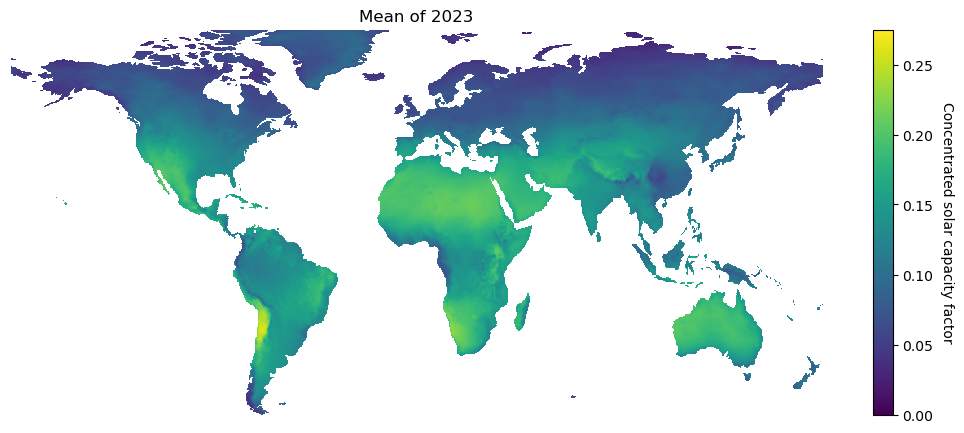

In [4]:
plot_capacity_factor('world_csp_CF_mean_2023.nc')

<Figure size 1000x500 with 0 Axes>

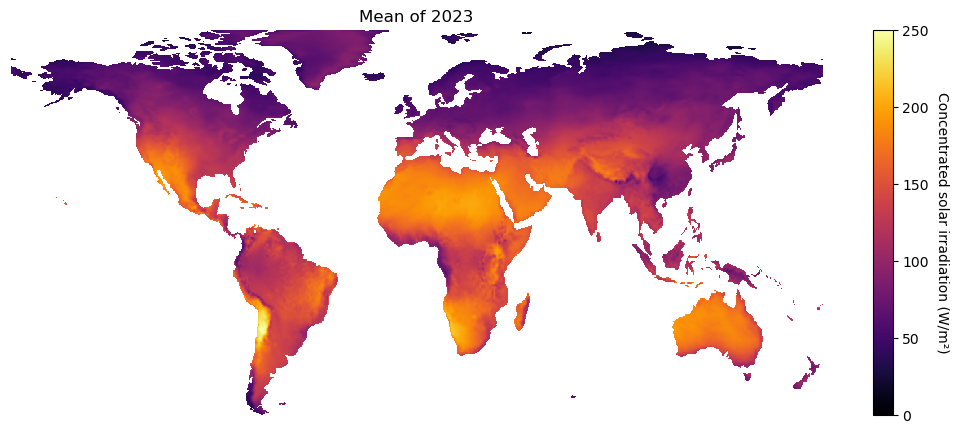

In [5]:
plot_capacity_factor('world_csp_CF_mean_2023.nc', irradiation=True)